In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

In [30]:

class RBFN:
    #initiizale RBF Network number of training sample and parameter 
    def __init__(self, num_centers=9, spread=1.0): 
        self.num_centers = num_centers
        self.spread = spread
        self.centers = None
        self.logistic = None
    
    #Compute RBF features for x 
    def _rbf(self, X):

        # Compute Euclidean distances between X and centers
        dists = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)

        # Compute Gaussian RBF
        G = np.exp(-(dists ** 2) / (2 * self.spread ** 2))
        return G
    
    #train RBF 
    
    def fit(self, X, y):

        #Determine RBF centers using K-Means clustering
        if self.num_centers > X.shape[0]:
            raise ValueError(f"Number of centers ({self.num_centers}) cannot exceed number of samples ({X.shape[0]}).")
        
        kmeans = KMeans(n_clusters=self.num_centers, random_state=0)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        
        #training data features 
        G = self._rbf(X)
        
        # Train Logistic Regression on RBF features
        self.logistic = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
        self.logistic.fit(G, y)
        
    def predict(self, X):
        G = self._rbf(X)
        y_pred = self.logistic.predict(G)
        return y_pred

def preprocess_image_filtered(image_path, min_width=20, min_height=20, max_width=300, max_height=300):

    #image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    # Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Binarize the image
    _, binary_image = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    #kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Morphological Opening to remove small noise
    opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Morphological Closing to connect fragmented parts
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on size
    filtered_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if min_width <= w <= max_width and min_height <= h <= max_height:
            filtered_contours.append(cnt)
    
    # Sort contours left to right
    sorted_contours = sorted(filtered_contours, key=lambda x: cv2.boundingRect(x)[0])
    
    # Extract character images
    characters = []
    for cnt in sorted_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Add padding just in case 
        padding = 5
        character = closed[max(y - padding, 0):y + h + padding, max(x - padding, 0):x + w + padding]
        characters.append(character)
    
    return characters

    # resize the charectetrs 
def resize_characters(characters, size=(50, 70)):
    resized_chars = [cv2.resize(char, size, interpolation=cv2.INTER_AREA) for char in characters]
    return resized_chars

def extract_features(characters):
    features = []
    for char in characters:
        # Ensure the character image is of the expected size
        if char.shape != (70, 50):
            char = cv2.resize(char, (50, 70), interpolation=cv2.INTER_AREA)
        
        # Divide into 5x7 (10x10 pixels each) segments
        avg_brightness = []
        grid_height = 70 // 7 
        grid_width = 50 // 5  
        for i in range(0, 70, grid_height):
            for j in range(0, 50, grid_width):
                grid = char[i:i+grid_height, j:j+grid_width]
                avg_brightness.append(np.mean(grid))
        
        # Normalize brightness values
        avg_brightness = np.array(avg_brightness) / 255.0
        features.append(avg_brightness)
    
    return np.array(features)

def train_classifier(features, labels, num_centers=9, spread=1.0):

    classifier = RBFN(num_centers=num_centers, spread=spread)
    classifier.fit(features, labels)
    return classifier

def recognize_characters(classifier, features):
    predictions = classifier.predict(features)
    recognized_text = ''.join(predictions)
    return recognized_text

def recognize_image(image_path, classifier):
    # Preprocess test image
    test_chars = preprocess_image_filtered(image_path)
    if not test_chars:
        raise ValueError("No characters detected in the test image.")
    test_chars = resize_characters(test_chars)
    test_features = extract_features(test_chars)
    
    # Recognize characters
    result = recognize_characters(classifier, test_features)
    print("Recognized Text:", result)
    return result

def visualize_characters(characters):
    num_chars = len(characters)
    cols = min(10, num_chars)
    rows = (num_chars // cols) + 1
    plt.figure(figsize=(15, 2 * rows))
    for idx, char in enumerate(characters):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(char, cmap='gray')
        plt.title(f'Char {idx+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Number of characters detected in training image after refinement: 9


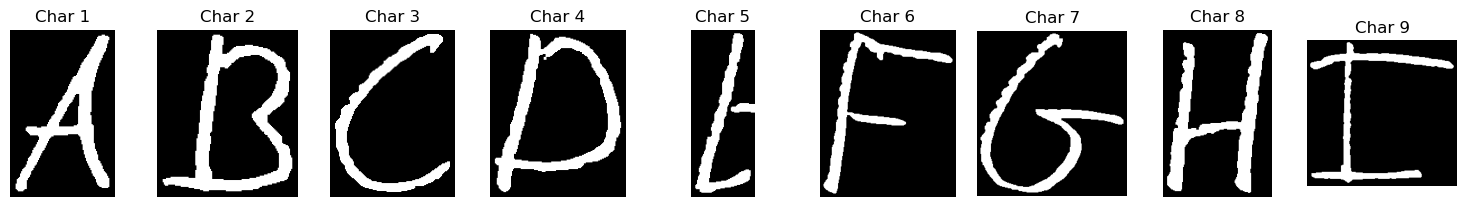

RBF Network trained successfully.
Validation Accuracy with 9 RBF neurons: 100.00%
Recognized Text: CBEFGGAFEAAA
RBF Network with reduced neurons trained successfully.
Validation Accuracy with 7 RBF neurons: 88.89%
Recognized Text: CBEFFFADEAAA


/Users/michaelrantisi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/michaelrantisi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:

def main():
    # training image
    train_image_path = '/Users/michaelrantisi/Downloads/462577436_1071068611136626_1467437800197465342_n.jpg'  
    
    # Preprocess and segment 
    train_chars = preprocess_image_filtered(train_image_path)
    print(f"Number of characters detected in training image after refinement: {len(train_chars)}")
    
    # Visualize detected characters
    visualize_characters(train_chars)
    
    #  training labels based on detected characters
    train_labels = list("ABCDEFGHI")  # 9 labels
    
    if len(train_labels) != len(train_chars):
        raise ValueError(f"Number of labels ({len(train_labels)}) does not match number of characters ({len(train_chars)}).")
    
    # Resize and extract features 
    train_chars_resized = resize_characters(train_chars)
    train_features = extract_features(train_chars_resized)
    
    #train and test samples
    X_train = train_features
    y_train = train_labels
    X_val = train_features 
    y_val = train_labels
    
    # Train the RBF 
    num_centers = 9  
    spread = 1.0    
    classifier = train_classifier(X_train, y_train, num_centers=num_centers, spread=spread)
    print("RBF Network trained successfully.")
    
    # Validate the classifier
    y_pred = classifier.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy with {num_centers} RBF neurons: {accuracy * 100:.2f}%")

    # Path to  test image 
    test_image_path = '/Users/michaelrantisi/Downloads/462569676_468271492645797_3807627985992406035_n.jpg' 
    
    # Recognize characters 
    recognized_text = recognize_image(test_image_path, classifier)
    

    # Reduce the number of RBF neurons
    reduced_num_centers = 7  
    classifier_reduced = train_classifier(X_train, y_train, num_centers=reduced_num_centers, spread=spread)
    print("RBF Network with reduced neurons trained successfully.")
    
    # Validate the reduced classifier
    y_pred_reduced = classifier_reduced.predict(X_val)
    accuracy_reduced = accuracy_score(y_val, y_pred_reduced)
    print(f"Validation Accuracy with {reduced_num_centers} RBF neurons: {accuracy_reduced * 100:.2f}%")
    
    # Recognize characters with the reduced classifier
    recognized_text_reduced = recognize_image(test_image_path, classifier_reduced)

if __name__ == "__main__":
    main()